In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import plot_roc_curve


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit


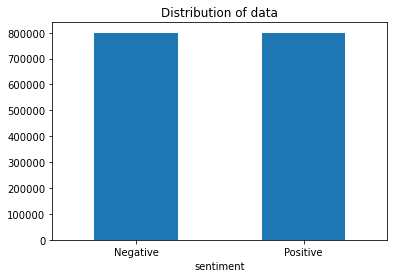

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/Users/connormcdonald/Desktop/Masters/MIT807/Data/training.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [3]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
          
## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [4]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText


In [5]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 83 seconds


In [6]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 2022)
print(f'Data Split done.')

Data Split done.


In [7]:
#total features = 242 041 for uni grams

#total features = 12 180 564 for uni, bi and trigrams

#total features = 11 938 523 for bi and trigrams


uni, unirange = 242041, (1,1)
unibi, unibirange = 3443736, (1,2)
unibitri, unibitrirange = 12180564,(1,3)
bitri, bitrirange = 11938523, (2,3)



def create_vectoriser(ngram, nrange):

    top20perc = int(0.2*ngram)
    vectoriser = TfidfVectorizer(ngram_range=nrange, max_features=top20perc) 
    vectoriser.fit(X_train)
    print(f'Vectoriser fitted.')
    print('No. of feature_words: ', len(vectoriser.get_feature_names()))
    return vectoriser


vectoriser = create_vectoriser(unibi, unibirange)

Vectoriser fitted.
No. of feature_words:  688747


In [8]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [9]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [10]:
MNBmodel = MultinomialNB(alpha=2)
MNBmodel.fit(X_train, y_train)
# model_Evaluate(MNBmodel)


cv = StratifiedShuffleSplit(n_splits=10, test_size=0.05, random_state=0)
accuracies = cross_val_score(estimator = MNBmodel, X = X_train, y = y_train, cv = cv)
print(f"Accuracy per fold: {accuracies}")
print("Mean Fold Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy per fold: [0.80743421 0.80802632 0.80519737 0.80652632 0.80588158 0.80671053
 0.80592105 0.80447368 0.80693421 0.80578947]
Mean Fold Accuracy: 80.63 %
Standard Deviation: 0.10 %


In [11]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.05, random_state=0)
accuracies = cross_val_score(estimator = SVCmodel, X = X_train, y = y_train, cv = cv)
print(f"Accuracy per fold: {accuracies}")
print("Mean Fold Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy per fold: [0.81613158 0.81447368 0.81084211 0.81386842 0.81464474 0.81540789
 0.81464474 0.81348684 0.81622368 0.81286842]
Mean Fold Accuracy: 81.43 %
Standard Deviation: 0.15 %


In [12]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.05, random_state=0)
accuracies = cross_val_score(estimator = LRmodel, X = X_train, y = y_train, cv = cv)
print(f"Accuracy per fold: {accuracies}")
print("Mean Fold Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy per fold: [0.82761842 0.82563158 0.82198684 0.82680263 0.82626316 0.82594737
 0.82634211 0.82434211 0.82813158 0.82459211]
Mean Fold Accuracy: 82.58 %
Standard Deviation: 0.17 %


In [13]:
# xgb = XGBClassifier(max_depth=6, n_estimators=1000)
# xgb.fit(X_train, y_train)
# model_Evaluate(xgb)

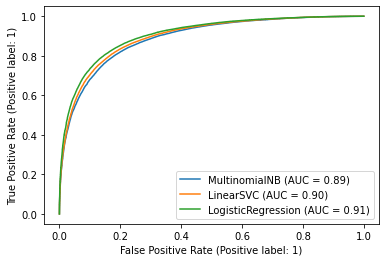

In [14]:
# bnb_roc = plot_roc_curve(BNBmodel, X_test, y_test)
mnb_roc = plot_roc_curve(MNBmodel, X_test, y_test)
svc_roc = plot_roc_curve(SVCmodel, X_test, y_test, ax=mnb_roc.ax_)
lr_roc = plot_roc_curve(LRmodel, X_test, y_test, ax=mnb_roc.ax_)
# xgb_roc = plot_roc_curve(xgb, X_test, y_test, ax=mnb_roc.ax_)
# xgb_roc.figure_.suptitle("ROC curve comparison")

In [15]:
# #Save models
# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/vectoriser-ngram-(1,2).pickle','wb')
# pickle.dump(vectoriser, file)
# file.close()

# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/Sentiment-LR.pickle','wb')
# pickle.dump(LRmodel, file)
# file.close()

# # file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/Sentiment-BNB.pickle','wb')
# # pickle.dump(BNBmodel, file)
# # file.close()

# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/Sentiment-MNB.pickle','wb')
# pickle.dump(MNBmodel, file)
# file.close()

# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/Sentiment-SVC.pickle','wb')
# pickle.dump(SVCmodel, file)
# file.close()

# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/Sentiment-XGB.pickle','wb')
# pickle.dump(xgb, file)
# file.close()



# #Save data
# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/X_train.pickle','wb')
# pickle.dump(X_train, file)
# file.close()

# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/X_test.pickle','wb')
# pickle.dump(X_test, file)
# file.close()

# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/y_train.pickle','wb')
# pickle.dump(y_train, file)
# file.close()


# file = open('/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Classification/Code/saved_models/y_test.pickle','wb')
# pickle.dump(y_test, file)
# file.close()


In [16]:
# def load_models():
#     '''
#     Replace '..path/' by the path of the saved models.
#     '''
    
#     # Load the vectoriser.
#     file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
#     vectoriser = pickle.load(file)
#     file.close()
#     # Load the LR Model.
#     file = open('..path/Sentiment-LRv1.pickle', 'rb')
#     LRmodel = pickle.load(file)
#     file.close()
    
#     return vectoriser, LRmodel

In [17]:
# def predict(vectoriser, model, text):
#     # Predict the sentiment
#     textdata = vectoriser.transform(preprocess(text))
#     sentiment = model.predict(textdata)
    
#     # Make a list of text with sentiment.
#     data = []
#     for text, pred in zip(text, sentiment):
#         data.append((text,pred))
        
#     # Convert the list into a Pandas DataFrame.
#     df = pd.DataFrame(data, columns = ['text','sentiment'])
#     df = df.replace([0,1], ["Negative","Positive"])
#     return df